# CS510 Assigment 5: BMGR Animal Data

Begin with general setup, imports and the like. See if there are any GPUs for TensorFlow to use. This is an automatic process and requires no configuration to work.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
fileSeparator = os.path.sep

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Import some functions from A3 which can showcase failed images given both the model, and the data. This is useful for demo purposes.

In [2]:
import cv2 as cv

def resizeImage(src, scale_percent):

    width = int(src.shape[1] * scale_percent / 100)
    height = int(src.shape[0] * scale_percent / 100)

    dsize = (width, height)
    return cv.resize(src.reshape(src.shape[0], src.shape[1]), dsize)

def showFailedImages(model, X, T, limit=None):
    
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    probModel = probability_model(X)

    cv.namedWindow("Failed Images", cv.WINDOW_NORMAL)
    cv.resizeWindow("Failed Images", 1920, 1080)
    
    counter = 0
    
    for index, percent in enumerate(probModel):
        
        if limit != None and counter > limit:
            
            break
            
        counter += 1
        listForm = list(percent.numpy())
        
        if T[index] != listForm.index(max(listForm)):
        
            image = resizeImage(X[index] * 255, 3000)
        
            ourResults = "Our Results: " + str(listForm.index(max(listForm)))
            correctResults = "Correct Results: " + str(T[index])
        
            cv.putText(image, ourResults, (20, 40), cv.FONT_HERSHEY_SIMPLEX, 0.75, (100, 255, 255), 2)
            cv.putText(image, correctResults, (20, 90), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

            cv.imshow('Failed Images', image)    
            key = cv.waitKey(1000)
    
            if key == 27:
        
                cv.destroyAllWindows()
                break
                
cv.destroyAllWindows()

## Task 1: Image Chips

Begin by creating a cross fold validation scheme. Taken from CS445, this is the method we are using.

In [3]:
def generate_stratified_partitions(X, T, n_folds, shuffle=True):

    def rows_in_fold(folds, k):
        
        all_rows = []
        
        for c, rows in folds.items():
            
            class_rows, starts, stops = rows
            all_rows += class_rows[starts[k]:stops[k]].tolist()
            
        return all_rows

    def rows_in_folds(folds, ks):
        
        all_rows = []
        
        for k in ks:
            
            all_rows += rows_in_fold(folds, k)
            
        return all_rows

    row_indices = np.arange(X.shape[0])
    
    if shuffle:
        
        np.random.shuffle(row_indices)
        
    folds = {}
    classes = np.unique(T)
    
    for c in classes:
        
        class_indices = row_indices[np.where(T[row_indices] == c)[0]]
        n_in_class = len(class_indices)
        n_each = int(n_in_class / n_folds)
        starts = np.arange(0, n_each * n_folds, n_each)
        stops = starts + n_each
        stops[-1] = n_in_class
        folds[c] = [class_indices, starts, stops]

    for test_fold in range(n_folds):
    
        train_folds = np.setdiff1d(range(n_folds), [test_fold])
        rows = rows_in_fold(folds, test_fold)
        Xtest = X[rows, :, :, :]
        Ttest = T[rows]
        rows = rows_in_folds(folds, train_folds)
        Xtrain = X[rows, :, :, :]
        Ttrain = T[rows]
        yield Xtrain, Ttrain, Xtest, Ttest

A simple indicator variable function.

In [4]:
def makeIndicatorVars(T):
    
    if T.ndim == 1:
        
        T = T.reshape((-1, 1)) 
    
    asUniqueArr = (T == np.unique(T)).astype(int)
    
    indicators = []
    
    for x in asUniqueArr:
        
        for i in range(len(x)):
            
            if x[i] == 1:
                
                indicators.append(i)
                
    return np.array(indicators)

The following function takes the network, and builds either a PDP or CNN with the specified number of layers, with the specified number of hidden units.

In [5]:
def run_k_fold_cross_validation(X, T, n_folds, hidden_units_array, epochs, act_func='relu', network_type="CNN", verbose=0):
    
    accuracyTrain = 0
    accuracyTest = 0
    
    for Xtrain, Ttrain, Xtest, Ttest in generate_stratified_partitions(X, T, n_folds):
        
        dataShape = Xtrain[0].shape
            
        if network_type == "PDP":
            
            model = models.Sequential()
            layers.Flatten(input_shape=dataShape)
            
            for i in range(1, len(hidden_units_array)):
                
                model.add(layers.Dense(hidden_units_array[i]))
                model.add(layers.Dropout(0.2))
                
            
        else:
            
            model = models.Sequential()
            model.add(layers.Conv2D(hidden_units_array[0], (3, 3), activation=act_func, input_shape=(dataShape)))
            
            for i in range(1, len(hidden_units_array)):
                
                model.add(layers.MaxPooling2D((2, 2)))
                model.add(layers.Conv2D(hidden_units_array[i], (3, 3), activation=act_func))
            
            model.add(layers.Flatten())
            model.add(layers.Dense(64, activation=act_func))
        
        model.add(layers.Dense(len(np.unique(Ttrain))))
        
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        trainIndicatorVars = makeIndicatorVars(Ttrain)
        testIndicatorVars = makeIndicatorVars(Ttest)

        model.fit(Xtrain, trainIndicatorVars, epochs=epochs, verbose=verbose)
        
        # evaluate verbose set to 0 because of display bug in tensorflow.
        accuracyTrain += model.evaluate(Xtrain, trainIndicatorVars, verbose=0)[1]
        accuracyTest += model.evaluate(Xtest, testIndicatorVars, verbose=0)[1]
                
        # showFailedImages(model, Xtest, Ttest, limit=10)
    
    return model, (Xtest, Ttest), (accuracyTrain / n_folds, accuracyTest / n_folds)

This function takes a pretrained network, and retrains it with our data.

In [6]:
def run_pretrained_network_test(X, T, n_folds, epochs, network_type=None, verbose=0):  
    
    accuracyTrain = 0
    accuracyTest = 0
    
    for Xtrain, Ttrain, Xtest, Ttest in generate_stratified_partitions(X, T, n_folds):
        
        base_model = network_type(weights = 'imagenet', include_top = False, input_shape=X[0].shape)
        # add a global spatial average pooling layer
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = layers.Dense(1024, activation='relu')(x)
        # and a logistic layer
        predictions = layers.Dense(len(np.unique(T)), activation='softmax')(x)
            
        model = models.Model(inputs=base_model.input, outputs=predictions)
        
        # first: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
            
        model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.sparse_categorical_accuracy])
        
        trainIndicatorVars = makeIndicatorVars(Ttrain)
        testIndicatorVars = makeIndicatorVars(Ttest)
        
        model.fit(Xtrain, trainIndicatorVars, epochs=epochs, verbose=verbose)
        
        # unfreeze and train again
        for layer in base_model.layers:
            layer.trainable = True
            
        model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.sparse_categorical_accuracy])
        
        model.fit(Xtrain, trainIndicatorVars, epochs=epochs, verbose=verbose)
        
        accuracyTrain += model.evaluate(Xtrain, trainIndicatorVars, verbose=0)[1]
        accuracyTest += model.evaluate(Xtest, testIndicatorVars, verbose=0)[1]
        
    return model, (Xtest, Ttest), (accuracyTrain / n_folds, accuracyTest / n_folds)

Method to run multiple models against the images, and create a dataframe with training and test accuracys.

In [7]:
def run_model_test(X, T, n_folds, models_hidden_units_array, epochs, act_func='relu', network_type="CNN", verbose=0):

    frame = []
    
    for model in models_hidden_units_array:
        
        print("Testing Model", model)
        _, _, (errorTrain, errorTest) = run_k_fold_cross_validation(X, T, n_folds, model, epochs=epochs, verbose=verbose)
        frame.append([network_type, act_func, model, epochs, errorTrain, errorTest])
        
    return pd.DataFrame(frame, columns=["Type", "Activation", "Model", "Epochs", "Training Accuracy", "Test Accuracy"])


def run_pretrainedmodel_test(X, T, n_folds, models, epochs, verbose=0):

    endFrame = []
    
    for model in models:
        
        print("Testing Model", model)
        
        last_model, (Xtest, Ttest), (errorTrain, errorTest) = run_pretrained_network_test(X, T, n_folds=n_folds, epochs=epochs, network_type=model, verbose=verbose)
        endFrame.append([model, epochs, errorTrain, errorTest])
        
        unique_labels = np.unique(Ttest)
        predictions = tf.argmax(tf.nn.softmax(last_model.predict(Xtest.astype('float32'))), axis=1)
        indicatorLabels = makeIndicatorVars(Ttest)
        confusion = tf.math.confusion_matrix(labels=indicatorLabels, predictions=predictions, num_classes=len(unique_labels))
        frame = pd.DataFrame(confusion.numpy(), index=unique_labels, columns=unique_labels)
        frame = frame.div(frame.sum(axis=1), axis=0) * 100
        frame = frame.style.background_gradient(cmap="Blues").format("{:.2f} %")
                
    return frame, pd.DataFrame(endFrame, columns=["Model", "Epochs", "Training Accuracy", "Test Accuracy"])

## Tests

We created a custom npz file with the data from the chips. We can then load the file through numpy simply and cleanly.

In [8]:
file = np.load("chipData.npz")
images = file['arr_0']
labels = file['arr_1']
time = file['arr_2']

X = images
T = labels
X.shape

(1812, 256, 256, 3)

In the following tests, we test different models on a 3 fold validation architecture. We run TensorFlow for 10 epochs with differing activation functions. We find that both the CNN and PDP style networks perform not very well. Both networks fail to hit testing accuracies greater than 50%. The pretrained networks on the other hand perform excellently, up to our standards. The network uses the InceptionResNetV2 architecture performs the best.

In [9]:
cnnframe = run_model_test(X, T, n_folds=3, models_hidden_units_array=[[10], [64, 10], [64, 64, 64]], epochs=10, act_func='tanh')
cnnframe

Testing Model [10]
Testing Model [64, 10]
Testing Model [64, 64, 64]


,Type,Activation,Model,Epochs,Training Accuracy,Test Accuracy
0,CNN,tanh,[10],10,0.672382,0.358344
1,CNN,tanh,"[64, 10]",10,0.574425,0.270403
2,CNN,tanh,"[64, 64, 64]",10,0.881317,0.401340


In [10]:
pdpframe = run_model_test(X, T, n_folds=3, models_hidden_units_array=[[10], [64, 10], [64, 64, 64]], epochs=10, network_type="PDP")
pdpframe

Testing Model [10]
Testing Model [64, 10]
Testing Model [64, 64, 64]


,Type,Activation,Model,Epochs,Training Accuracy,Test Accuracy
0,PDP,relu,[10],10,0.221859,0.221874
1,PDP,relu,"[64, 10]",10,0.952349,0.357560
2,PDP,relu,"[64, 64, 64]",10,0.968278,0.394804


In [11]:
conf, pretrainedframe = run_pretrainedmodel_test(X, T, n_folds=3, models=[
    tf.keras.applications.vgg19.VGG19,
    tf.keras.applications.inception_v3.InceptionV3,
    tf.keras.applications.inception_resnet_v2.InceptionResNetV2,
    tf.keras.applications.resnet_v2.ResNet50V2
], epochs=10, verbose=0)

pretrainedframe

Testing Model <function keras_modules_injection.<locals>.wrapper at 0x000001B6B879D288>
Testing Model <function keras_modules_injection.<locals>.wrapper at 0x000001B6B87875E8>
Testing Model <function keras_modules_injection.<locals>.wrapper at 0x000001B6B87870D8>
Testing Model <function keras_modules_injection.<locals>.wrapper at 0x000001B6B87975E8>


,Model,Epochs,Training Accuracy,Test Accuracy
0,<function keras_modules_injection.<locals>.wra...,10,0.772907,0.748377
1,<function keras_modules_injection.<locals>.wra...,10,0.307393,0.299096
2,<function keras_modules_injection.<locals>.wra...,10,0.727522,0.688028
3,<function keras_modules_injection.<locals>.wra...,10,0.989502,0.925022


In [12]:
conf

,Bighorn_Sheep,Bobcat,Coyote,Gray_Fox,Javelina,Mule_Deer,Raptor,White_Tailed_Deer
Bighorn_Sheep,100.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %
Bobcat,0.00 %,85.29 %,8.82 %,1.47 %,1.47 %,1.47 %,1.47 %,0.00 %
Coyote,0.00 %,5.88 %,88.24 %,2.94 %,0.00 %,2.94 %,0.00 %,0.00 %
Gray_Fox,0.00 %,0.00 %,4.29 %,95.71 %,0.00 %,0.00 %,0.00 %,0.00 %
Javelina,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %,0.00 %,0.00 %,0.00 %
Mule_Deer,8.82 %,0.00 %,7.35 %,0.00 %,0.00 %,64.71 %,0.00 %,19.12 %
Raptor,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %,0.00 %
White_Tailed_Deer,0.00 %,0.00 %,1.47 %,0.00 %,0.00 %,10.29 %,0.00 %,88.24 %


In [13]:
cnntestdata = list(cnnframe["Test Accuracy"])
pdptestdata = list(pdpframe["Test Accuracy"])
pretraintestdata = list(pretrainedframe["Test Accuracy"])

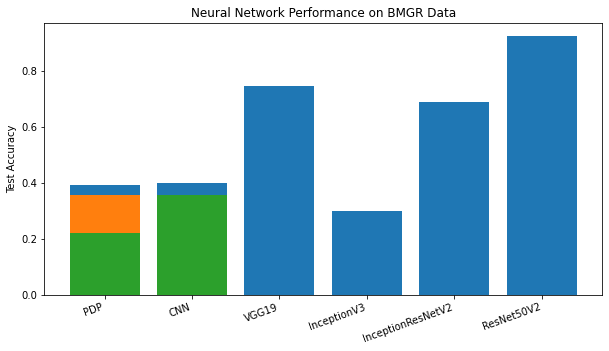

In [34]:
accuracies = [pdptestdata[-1], cnntestdata[-1]] + pretraintestdata
labels = ["PDP", "CNN", "VGG19", "InceptionV3", "InceptionResNetV2", "ResNet50V2"]
x = np.arange(6)

plt.figure(figsize=(10,5))
plt.bar(x, accuracies)
plt.bar(x[:2], [pdptestdata[-2], cnntestdata[-2]])
plt.bar(x[:2], [pdptestdata[-3], cnntestdata[-3]])
plt.title("Neural Network Performance on BMGR Data")
plt.ylabel("Test Accuracy")
plt.xticks(x, labels, rotation='20', ha='right');

## Part 2: Raw Data

### Applying Inception-ResnetV2 RCNN to Dataset Images for Automatic Cropping

For part 2 of this assignment, we apply a pretrained Faster-RCNN using Inception-ResnetV2 as it's underlying architecture in an attempt to automatically locate the animal in a larger image. We uniformly scale the image down to 1/3rd of it's original size when performing the detection, maintaining aspect ratio. After detecting the location, we crop the image to that location and resize it to 256x256. We maintain the aspect ratio to prevent image distortion and instead pad the image with 0 values.

For now, if nothing was detected by our detector, we simply ignore it. This issue will be dealt with later.

In [15]:
CLASS_NAMES = tf.convert_to_tensor(['Bighorn_Sheep', 'Bobcat', 'Coyote', 'Gray_Fox', 
                                    'Javelina', 'Mule_Deer', 'Raptor', 'White_Tailed_Deer'])

# Reduce size but maintain aspect ratio
IMG_WIDTH = 2592 // 3
IMG_HEIGHT = 1840 // 3
IMG_CROP_HEIGHT = 1840
IMG_CROP_WIDTH = 2592

# Increase this if you want to/have enough memory to
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
detector = hub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1").signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
def get_label(path):
    
    return tf.cast(CLASS_NAMES == tf.strings.split(path, os.path.sep)[2], tf.int32)

def decode_img(img):
    
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # crop the pointless bar form the bottom and resize the image to the desired size.
    img = img[0:IMG_CROP_HEIGHT, 0:IMG_CROP_WIDTH]
    
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    
    label = get_label(file_path)
    
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

In [18]:
list_ds = tf.data.Dataset.list_files('data/raw_data/*/*', shuffle=True)

In [19]:
labeled_ds = list_ds.map(process_path)

In [20]:
def prepare_for_training(ds):

    # Repeat forever
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_ds = prepare_for_training(labeled_ds)
ds_iter = iter(train_ds)

In [22]:
# We don't want trees! We want animals!
valid_classes = tf.convert_to_tensor([b'Animal', b'Mammal', b'Deer', b'Goat', b'Dog',
                                      b'Carnivore', b'Lion', b'Horse', b'Antelope',
                                      b'Sheep', b'Bird', b'Raven', b'Eagle', b'Chicken',
                                      b'Cattle'])

In [23]:
def show_batches_cropped(detector, dataset):
    
    image_batch, label_batch = next(dataset)
    num_images = len(image_batch)
    plt.figure(figsize=(15, 4*num_images))
    
    for i in range(num_images):
        
        plt.subplot(num_images, 3, 3*i+1)
        
        img = image_batch[i]
        plt.imshow(img)
        
        plt.title(CLASS_NAMES[label_batch[i] > 0][0].numpy().decode('utf-8'))
        
        detector_output = detector(img[tf.newaxis, ...])
        
        classes = detector_output['detection_class_entities']
        
        # Get the index of all objects detected which fit our class list
        class_indices = [i for i, class_ent in enumerate(classes) if class_ent in valid_classes]
        
        # Sorted by confidence, so highest confidence will always be the first element
        animal_index = None
        
        if not class_indices:
            
            continue
        
        animal_index = class_indices[0]
        
        ymin, xmin, ymax, xmax = tuple(detector_output['detection_boxes'][animal_index])
        
        plt.subplot(num_images, 3, 3*i+2)
        cropped = img[int(ymin*(IMG_HEIGHT-1)) : int(ymax*(IMG_HEIGHT-1)), int(xmin*(IMG_WIDTH-1)) : int(xmax*(IMG_WIDTH-1))]
        plt.imshow(cropped)
        plt.title(classes[animal_index].numpy().decode('utf-8'))
        
        plt.subplot(num_images, 3, 3*i+3)
        resized = tf.image.resize_with_pad(cropped, 256, 256)
        plt.imshow(resized)
        plt.title('Resized to 256x256')

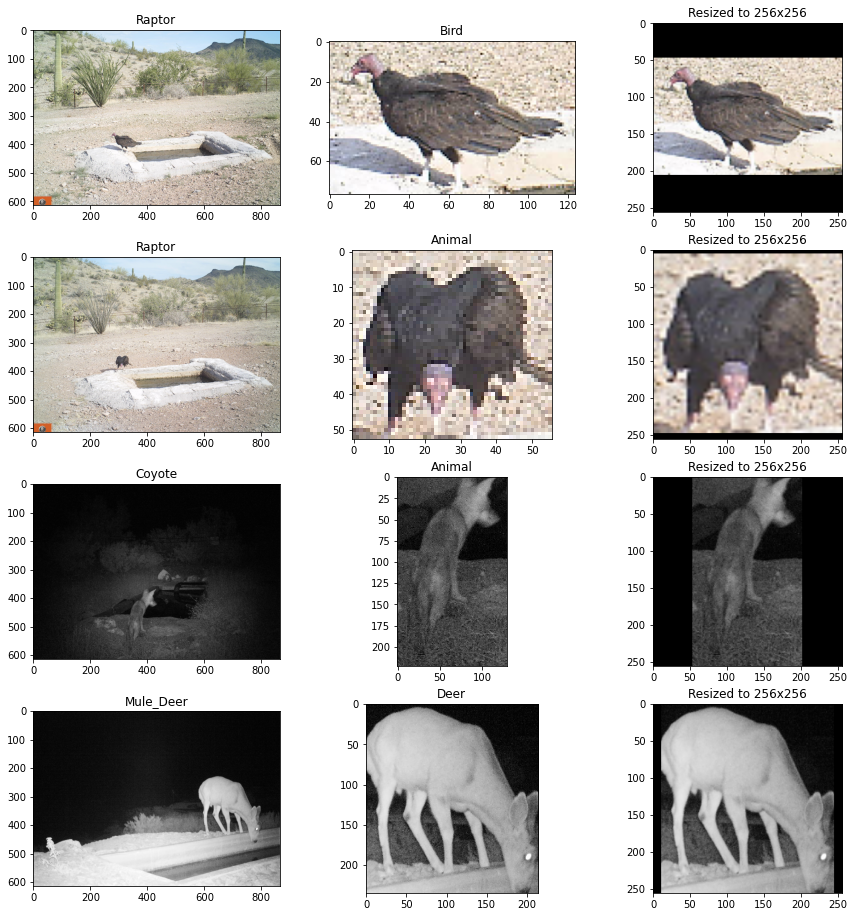

In [24]:
# If you rerun this, it should give new output each time.
# Shown in format: Original Image, Cropped image with it's detected label.
show_batches_cropped(detector, ds_iter)

### Getting a Transformed Dataset

This is code which will convert images based on the transformation shown above. However, it will also save them. The images are selected in a random order so over time, the distribution of animal images downloaded will roughly equal the distribution of animals in the original dataset if the download is stopped at some point.

In [25]:
def downloadImages(detector, dataset, dirToDownload):
    
    i = 0
    
    for image_batch, label_batch in dataset:
        
        for img, label in zip(image_batch, label_batch):

            detector_output = detector(img[tf.newaxis, ...])
            classes = detector_output['detection_class_entities']
            
            # Get the index of all objects detected which fit our class list
            class_indices = [i for i, class_ent in enumerate(classes) if class_ent in valid_classes]
            
            # Sorted by confidence, so highest confidence will always be the first element
            animal_index = None
            
            if not class_indices:
                # Skipping images which have no animal detected
                continue
            
            animal_index = class_indices[0]

            ymin, xmin, ymax, xmax = tuple(detector_output['detection_boxes'][animal_index])
            cropped = img[int(ymin * (IMG_HEIGHT-1)) : int(ymax * (IMG_HEIGHT-1)), int(xmin * (IMG_WIDTH-1)) : int(xmax * (IMG_WIDTH-1))]
            resized = tf.image.resize_with_pad(cropped, 256, 256)
            resized = tf.image.convert_image_dtype(resized, tf.uint8)
            
            jpg = tf.io.encode_jpeg(resized)
            label = CLASS_NAMES[label > 0][0].numpy().decode('utf-8')
            tf.io.write_file(os.path.join(dirToDownload, label, label + '_' + str(i) + '.jpg'), jpg)
            
            i += 1
            print("Cropped", i, "Images", end='\r')

In [ ]:
downloadImages(detector, ds_iter, os.path.join('data', 'raw_crop'))

### Training a model over the transformed dataset

Finally, with our preprocessed data, we need to perform a test to see how well it performs. Since it is not the focus of the assignment, we are going to test it only once with the best performing network from part 1 of the assignment.

In [26]:
def get_label(path):
    return tf.cast(CLASS_NAMES == tf.strings.split(path, os.path.sep)[2], tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    return tf.image.convert_image_dtype(img, tf.float32)

def process_path(file_path):
    
    label = get_label(file_path)
    
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

In [27]:
list_ds = tf.data.Dataset.list_files('data/raw_crop/*/*', shuffle=True)

In [28]:
labeled_ds = list_ds.map(process_path)

In [29]:
prepared_ds = prepare_for_training(labeled_ds)

In [30]:
SIZE_OF_TEST_DS = 200
SIZE_OF_TEST_DS = SIZE_OF_TEST_DS // BATCH_SIZE
test_ds = prepared_ds.take(SIZE_OF_TEST_DS)
train_ds = prepared_ds.skip(SIZE_OF_TEST_DS)

In [32]:
epochs = 5
verbose = True

In [35]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights = 'imagenet', include_top = False, input_shape=(256, 256, 3))
# add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
            
model = models.Model(inputs=base_model.input, outputs=predictions)
        
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False
            
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.categorical_accuracy])
        
model.fit(train_ds, epochs=epochs, verbose=verbose)
        
# unfreeze and train again
for layer in base_model.layers:
    layer.trainable = True
            
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.categorical_accuracy])
        
model.fit(train_ds, epochs=epochs, verbose=verbose)
        
accuracyTrain = model.evaluate(train_ds, verbose=0)[1]
accuracyTest = model.evaluate(test_ds, verbose=0)[1]
accuracyTrain, accuracyTest

Epoch 1/5
7376/7376 [==============================] - 101s 14ms/step - loss: 0.9087 - categorical_accuracy: 0.7165
Epoch 2/5
7376/7376 [==============================] - 90s 12ms/step - loss: 0.8419 - categorical_accuracy: 0.7630
Epoch 3/5
7376/7376 [==============================] - 90s 12ms/step - loss: 0.8462 - categorical_accuracy: 0.77801s -
Epoch 4/5
7376/7376 [==============================] - 90s 12ms/step - loss: 0.8581 - categorical_accuracy: 0.7864
Epoch 5/5
7376/7376 [==============================] - 89s 12ms/step - loss: 0.8706 - categorical_accuracy: 0.7893
Epoch 1/5
7376/7376 [==============================] - 288s 39ms/step - loss: 0.5292 - categorical_accuracy: 0.8320
Epoch 2/5
7376/7376 [==============================] - 266s 36ms/step - loss: 0.3102 - categorical_accuracy: 0.9012
Epoch 3/5
7376/7376 [==============================] - 266s 36ms/step - loss: 0.2275 - categorical_accuracy: 0.9258
Epoch 4/5
7376/7376 [==============================] - 266s 36ms/step - 

(0.9655605, 0.965)

In [36]:
conf_ds = test_ds

In [37]:
conf_ds = conf_ds.unbatch()

images = []
labels = []
for img, label in conf_ds:
    images.append(img)
    labels.append(label)
labels = tf.argmax(labels, axis=1)
images = tf.convert_to_tensor(images)

predictions = model.predict(images)
pred = tf.argmax(predictions, axis=1)

classNames = [val.numpy().decode('utf-8') for val in CLASS_NAMES]

confusion = tf.math.confusion_matrix(labels=labels, predictions=pred, num_classes=len(classNames))
frame = pd.DataFrame(confusion.numpy(), index=classNames, columns=classNames)
frame = frame.div(frame.sum(axis=1), axis=0) * 100
frame = frame.style.background_gradient(cmap="Blues").format("{:.2f} %")
display(frame)

,Bighorn_Sheep,Bobcat,Coyote,Gray_Fox,Javelina,Mule_Deer,Raptor,White_Tailed_Deer
Bighorn_Sheep,92.50 %,0.00 %,2.50 %,0.00 %,0.00 %,0.00 %,0.00 %,5.00 %
Bobcat,0.00 %,85.71 %,0.00 %,0.00 %,0.00 %,14.29 %,0.00 %,0.00 %
Coyote,0.00 %,0.00 %,95.35 %,0.00 %,0.00 %,0.00 %,4.65 %,0.00 %
Gray_Fox,0.00 %,0.00 %,0.00 %,100.00 %,0.00 %,0.00 %,0.00 %,0.00 %
Javelina,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %,0.00 %,0.00 %,0.00 %
Mule_Deer,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %,0.00 %,0.00 %
Raptor,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,3.85 %,92.31 %,3.85 %
White_Tailed_Deer,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %


## Final notes

- In theory, the cropping could be much better if it were fine tuned to the training set. The RCNN we used is a bit overkill for this purpose, since it is designed to recognize hundreds of different classes. If a new RCNN was trained to recognize the 8 animal classes we are covering instead, not only would runtime performance and accuracy probably improve, but additionally, the entire process of classifying an animal in an image would be much more streamlined as the use of a single network rather than as one network for prepocessing and another for classification.